In [1]:
pip install lacosmic

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow-gpu

  Using cached tensorflow_gpu-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Boyko\\AppData\\Local\\Programs\\Python\\Python38\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [3]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

In [5]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [7]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from io import BytesIO
import re
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
import lacosmic
import random
import tensorflow as tf

In [8]:
BASE_URL = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/"

# Step 1 – Retrieving and Plotting Image Files
### The utility Loader defined above class was developed for this task, which facilitates downloading and storing images in the file structure assumed by the tools for the other tasks

In [9]:
class Loader:
    def __init__(self, base_url = BASE_URL):
        self.base_url = base_url
        if not os.path.exists("Images"):
            os.mkdir("Images")
    
    def get_time(self, year, day):
        return "_".join([year, day])
    
    def get_folder_path(self, year, day):
        return "/".join(["Images", self.get_time(year, day), "img"])
    
    def get_file_path(self, year, day, image):
        return "/".join([self.get_folder_path(year, day), image])
    
    def image_exists(self, year, day, image): 
        folder_path = "/".join(["Images", self.get_time(year, day), "img"])
        filepath = self.get_folder_path(year, day)
        if not os.path.exists(filepath):
            return False
        return os.path.exists(filepath + "/" + image)
    
    def download_image(self, year, day, image):
        if self.image_exists(year, day, image):
#             print("Image already exists")
            return None
         
        path = "_".join([year, day])
        
        if not os.path.exists("/".join(["Images", path])):
            os.mkdir("/".join(["Images", path]))
            
        filepath = "/".join(["Images", path, "img"])
        if not os.path.exists(filepath):
            os.mkdir(filepath)
            
        url = "/".join([self.base_url, path, image])
        r = requests.get(url)
        open("/".join([filepath, image]), 'wb').write(r.content)
    
    def process_img(self, year, day, image):
        img_file = open(self.get_file_path(year, day, image), "rb")
        img_bytes = bytearray()
        reading_header = True
        rows = None
        cols = None
        sample_bits = None
        for line in img_file.readlines():
            if not reading_header:
                img_bytes.extend(line)
            else:
                header_line = line.strip().decode("utf-8")
                if "END" == header_line:
                    reading_header = False
                elif "LINES" in header_line:
                    rows = int(header_line.split("=")[1])
                elif "LINE_SAMPLES" in header_line:
                    cols = int(header_line.split("=")[1])
                elif "SAMPLE_BITS" in header_line:
                    sample_bits = header_line.split("=")[1].strip()
        try:
            img_sample_bits = np.frombuffer(
                img_bytes,
                dtype="uint" + sample_bits
            )

            extra_byte_count = img_sample_bits.size - rows * cols
            img_sample_bits = img_sample_bits[extra_byte_count:]
            img_resized = np.resize(img_sample_bits, (rows,cols))
            return Image.fromarray(img_resized)
        except:
            print("FAILED READING IMG: ", image)
    
    def convert_all_to_png(self, year, day):
        png_dir = "/".join(["Images", self.get_time(year, day), "png"])
        if not os.path.exists(png_dir):
            os.mkdir(png_dir)
        pngs = set(os.listdir(png_dir))
        imgs = os.listdir("/".join(["Images", self.get_time(year, day), "img"]))
        for img in imgs:
            #print(img)
            if not img + ".png" in pngs:
                try:
                    im = self.process_img(year, day, img)
                    im.save("/".join([png_dir, img]) + ".png",format="png")
                except:
                    print("FAILED PNG CONVERSION:", img)
                    
    def download_and_display_image(self, year, day, image, display=False):
        self.download_image(year, day, image)
        im = self.process_img(year, day, image)
        if display:
            plt.figure()
            plt.imshow(np.asarray(im), cmap="gray", vmin=0, vmax=255)
#            im = Image.open("")
#            im.show()
        
    def download_and_display_all_images_from_folder(self, year, day, display=False):
        time = self.get_time(year, day)
        url = "/".join([self.base_url, time])
        request = requests.get(url)
        soup = BeautifulSoup(request.content, "html.parser")
        print("Retrieving folder content")
        images = soup.find_all("a", text=re.compile(".IMG"))
        x = 0
        j = len(images)
        for image in images:
            self.download_and_display_image(year, day, image.get_text(), display)
            x += 1
            print (str(x) + "/" + str(j), end="\r", flush=True)


Retrieving folder content
Retrieving folder content
FAILED READING IMG:  EW0220137532B.IMG
FAILED READING IMG:  EW0220137532B.IMG
FAILED PNG CONVERSION: EW0220137532B.IMG


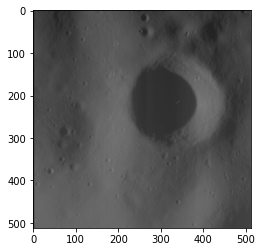

In [10]:
l = Loader()

l.download_and_display_image("2014", "215", "EN1049375684M.IMG", display=True)

l.download_and_display_all_images_from_folder("2011", "156", display=False)

l.download_and_display_all_images_from_folder("2011", "207", display=False)

###For next steps
l.convert_all_to_png("2011", "207")
l.convert_all_to_png("2011", "156")
l.convert_all_to_png("2014", "215")

# Step 2 – Dataset preparation

For the Dataset preperation a utility loader class was built.

For automation of the labeling process for cosmic rays, the L.A. Cosmic algorithm, that utilises Laplacian edge detection, was used:

https://lacosmic.readthedocs.io/en/latest/

L.A. cosmic generates a mask that indicate where cosmic rays could be located. The cosmic ray islands are then boxed into 60x60 squares. If two boxes overlap, they are merged. To reduce bias from all cosmic rays being positioned in the center of the frame, image augmentation is used. There is a 15% probability for 10 pixels to be trimmed from each side and a 5% probability for 15 pixels to be removed.

For labeling images with no cosmic rays, a day was picked out manually, where images did not contain many cosmic rays, and random segments of these images were cut out. The images were trimmed in the same way mentioned above to avoid the neural network falsely detecting image streching traces as a feature to classify on. 

The contrast was tripled on all images so as to make Cosmic Rays more easily detectable.

In [11]:
def get_bounding_box(r, c, mask):
    padding = 30
    dirs =  []
    for p in range(1, padding):
        dirs.append([0, p])
        dirs.append([p, 0])
        dirs.append([0, -p])
        dirs.append([-p, 0])
        dirs.append([p, p])
        dirs.append([p, -p])
        dirs.append([-p, p])
        dirs.append([-p, -p])
    max_r = r
    min_r = r
    max_c = c
    min_c = c
    q = []
    q.append([r, c])
    while (len(q) > 0):
        [cr, cc] = q.pop(0)
        mask[cr, cc] = False
        for d in dirs:
            nr = cr + d[0]
            nc = cc + d[1]
            if nr > 0 and nr < len(mask) and nc > 0 and nc < len(mask[0]):
                max_r = max(nr, max_r)
                min_r = min(nr, min_r)
                max_c = max(nc, max_c)
                min_c = min(nc, min_c)
            if nr > 0 and nr < len(mask) and nc > 0 and nc < len(mask[0]) and mask[nr][nc]:
                mask[nr, nc] = False
                q.append([nr, nc])
    return [max_r, min_r, max_c, min_c]
    
class Image_processor:
    def __init__(self, year, day):
        self.day_path = "/".join(["Images", year + "_" + day, "png"])
    
    def process_single_image_cosmic_rays(self, image):
        folder_name = self.day_path + "/" + image + "_" + "processed"
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        imgpath = self.day_path + "/" + image
        imgpng = np.array(Image.open(imgpath).convert("L"))
        print(imgpng.shape)
        (img, mask) = lacosmic.lacosmic(imgpng.astype(np.float), contrast=3.0, cr_threshold=3.75, 
                                        neighbor_threshold=0.3, effective_gain=1.0,
                                        readnoise= 4.5, maxiter=1, border_mode=u'mirror',
                                        background=None, mask=None, error=None)
        
        boxes = []
        print("Getting bounding boxes")
        for r in range(len(mask)):
            for c in range(len(mask[0])):
                if mask[r, c]:
                    boxes.append(get_bounding_box(r, c, mask))
        
        #im = Image.fromarray(np.where(mask == False, img, 0))#img)
        print("Number of boxes: " + str(len(boxes)))
        im = Image.fromarray(img)
        i = 1
        for box in boxes:
            for x in range(len(box)):
                r = random.random()
                if r < 0.15:
                    box[x] += 10
                if r >= 0.95:
                    box[x] += + 15
            [max_r, min_r, max_c, min_c] = box
            cosmic_ray_candidate = Image.open(imgpath).crop((min_c, min_r, max_c, max_r)).convert("RGB")
            cosmic_ray_candidate.save(folder_name + "/" + str(i) + ".png")#, format="png")
            i += 1
    
    def process_folder_cosmic_rays(self):
        j = 0
        m = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
#             print (str(j) + "/" + str(m))
#             j += 1
            if file.endswith(".png"):
                self.process_single_image_cosmic_rays(file)
                
    def process_single_image_random_sample(self, image):
        folder_name = self.day_path + "/" + image + "_" + "processed"
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        imgpath = self.day_path + "/" + image
        img = Image.open(imgpath)
        max_width, max_height = img.size
        cols = np.random.randint(low = 1, high = max_width, size = 120)
        rows = np.random.randint(low = 1, high = max_height, size = 120)
        for i in range(120):
            default_padding = 30
            borders = [max(0, cols[i] - 30), max(0, rows[i] - 30), min(cols[i] + 30, max_width - 1), min(rows[i] + 30, max_height - 1)]
            for x in range(len(borders)):
                r = random.random()
                if r < 0.15:
                    borders[x] += 10
                if r >= 0.95:
                    borders[x] += + 15
            random_img = img.crop((borders[0], borders[1], borders[2], borders[3])).convert("RGB")
            random_img.save(folder_name + "/" + str(i) + ".png")

    def process_folder_random_images(self):
        j = 0
        m = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
#             print (str(j) + "/" + str(m), end="\r", flush=True)
#             j += 1
            if file.endswith(".png"):
                self.process_single_image_random_sample(file)
    
    def get_data_single_image(self, directory_path):
        images = []
        for file in os.listdir(directory_path):
            img = Image.open(directory_path + "/" + file).resize((50, 50))
            img = ImageEnhance.Contrast(img).enhance(3)
            im = np.array(img, dtype="f")
            images.append(im)
        return np.array(images, dtype="f")
    
    def load_day(self):
        samples = []
        i = 0
        j = len(os.listdir(self.day_path))
        for file in os.listdir(self.day_path):
            if file.endswith("_processed"):
                image_samples = self.get_data_single_image(self.day_path + "/" + file)
                samples.extend(image_samples)
            i += 1
            print (str(i) + "/" + str(j), end="\r", flush=True)
        return np.array(samples)

In [12]:
i_cosmic_ray = Image_processor("2011", "156")
i_cosmic_ray.process_folder_cosmic_rays()
cosmic_ray_data = i_cosmic_ray.load_day()
i_non_cosmic_ray = Image_processor("2011", "207")
i_non_cosmic_ray.process_folder_random_images()
non_cosmic_ray_data = i_non_cosmic_ray.load_day()
print("Cosmic ray samples: " , len(cosmic_ray_data))
print("Non-cosmic ray samples: ", len(non_cosmic_ray_data))

(1024, 1024)
INFO: Iteration 1: Found 1618 cosmic-ray pixels, Total: 1618 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 295
(1024, 1024)
INFO: Iteration 1: Found 1591 cosmic-ray pixels, Total: 1591 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 281
(1024, 1024)
INFO: Iteration 1: Found 1597 cosmic-ray pixels, Total: 1597 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 288
(1024, 1024)
INFO: Iteration 1: Found 473 cosmic-ray pixels, Total: 473 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 117
(1024, 1024)
INFO: Iteration 1: Found 607 cosmic-ray pixels, Total: 607 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 145
(1024, 1024)
INFO: Iteration 1: Found 542 cosmic-ray pixels, Total: 542 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 118
(1024, 1024)
INFO: Iteration 1: Found 555 cosmic-ray pixels, Total: 555 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 127
(1024, 1024)
INFO: Iteration 1: Found 524 

(1024, 1024)
INFO: Iteration 1: Found 1677 cosmic-ray pixels, Total: 1677 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 157
(1024, 1024)
INFO: Iteration 1: Found 3683 cosmic-ray pixels, Total: 3683 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 128
(1024, 1024)
INFO: Iteration 1: Found 3797 cosmic-ray pixels, Total: 3797 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 136
(1024, 1024)
INFO: Iteration 1: Found 741 cosmic-ray pixels, Total: 741 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 118
(1024, 1024)
INFO: Iteration 1: Found 575 cosmic-ray pixels, Total: 575 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 98
(1024, 1024)
INFO: Iteration 1: Found 222 cosmic-ray pixels, Total: 222 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 56
(1024, 1024)
INFO: Iteration 1: Found 196 cosmic-ray pixels, Total: 196 [lacosmic.lacosmic]
Getting bounding boxes
Number of boxes: 45
(1024, 1024)
INFO: Iteration 1: Found 156 cos

In [13]:
#Prepare data for classification
data = np.concatenate((non_cosmic_ray_data, cosmic_ray_data), axis = 0) / 255.0
labels = np.zeros(data.shape[0])
labels[:non_cosmic_ray_data.shape[0]] = 0
labels[non_cosmic_ray_data.shape[0]:] = 1
indecies = np.arange(data.shape[0])
np.random.shuffle(indecies)
labels = labels[indecies]
data = data[indecies]

#Leave 1/5 of data for testing
slice_index = int(labels.shape[0] / 5)
training_data = data[slice_index:]
training_labels = labels[slice_index:]
test_data = data[:slice_index]
test_labels = labels[:slice_index]
print("Training data shape: ", training_data.shape)
print("Test data shape: ", test_data.shape)
# Image.fromarray((training_data[25] * 255).astype(np.uint8)).show()

Training data shape:  (22275, 50, 50, 3)
Test data shape:  (5568, 50, 50, 3)


# Step 3 – Machine Learning Algorithm

The following CNN model is to be used for binary classification, where 1 is the label for cosmic rays and 0 is the label for non-cosmic ray images.

In [14]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return cnn_model
    
cnn_model = build_cnn_model()
# print(training_data[0].shape)
print(cnn_model.predict(training_data[[0]]))
print(cnn_model.summary())

[[0.49872598]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dense_1 (Dense)              (None, 1)   

In [15]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(x=training_data, y=training_labels, batch_size = 1000, epochs=5)

Epoch 1/5
23/23 [==============================] - 24s 1s/step - loss: 0.5779 - accuracy: 0.5768
Epoch 2/5
23/23 [==============================] - 24s 1s/step - loss: 0.3229 - accuracy: 0.8537
Epoch 3/5
23/23 [==============================] - 24s 1s/step - loss: 0.2584 - accuracy: 0.9030
Epoch 4/5
23/23 [==============================] - 23s 1s/step - loss: 0.2081 - accuracy: 0.9319
Epoch 5/5
23/23 [==============================] - 23s 994ms/step - loss: 0.1648 - accuracy: 0.9479


In [16]:
test_loss, test_acc = cnn_model.evaluate(test_data, test_labels)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

174/174 [==============================] - 2s 9ms/step - loss: 0.1297 - accuracy: 0.9558
Test accuracy 0.9558189511299133
Test loss 0.12965622544288635


# Pipeline for ingesting a single image

The current network can be used to identify tiles that potentially contain cosmic rays. The is segmented into 50x50 tiles. Only tiles with labeled with a value above a threshold are identified as a cosmic ray and displayed.

Original image:
[[0.736446]]


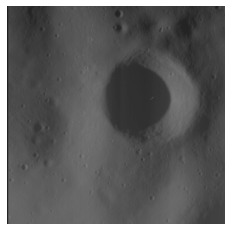

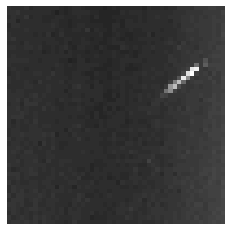

In [17]:
def ingest_image(image_png_path, threshold = 0.6):
    image = Image.open(image_png_path)
    print("Original image:")
    plt.figure()
    plt.axis('off')
    plt.imshow(np.asarray(image), cmap="gray", vmin=0, vmax=255)
    width, height = image.size
    length = 50
    window = 50
    r = 0
    c = 0
    while r < height:
        c = 0
        while c < width:
            im = image.crop((c, r, min(c + length, width), min(r + length, height))).resize((length, length)).convert("RGB")
            im = ImageEnhance.Contrast(im).enhance(4)
            arr = np.array(im) / 255.0
            ar = np.expand_dims(arr, axis=0)
            prediction = cnn_model.predict(ar)
#             print(prediction)
            if (prediction[0] > threshold):
                print(prediction)
                plt.figure()
                plt.axis('off')
                plt.imshow(np.asarray(im), cmap="gray", vmin=0, vmax=255)
            c += window
        r += window

ingest_image("/".join(["Images", "2014_215", "png", "EN1049375684M.IMG.png"]))